## Feature Ideas

- Basics
    - Body Length
    - Title Length
    - Num tags
    - Post Age in weeks
    - Post ordinal (ie what number of post this is for the user 1st, 2nd, 3rd, etc.)
    - Post type (Q or A)
    - Current Num Votes?
    - Deleted/undeleted weeks ago
    - Locked/unlocked weeks ago
    - Closed/reopened weeks ago
    - Bumped weeks ago
    - Tweeted weeks ago

- Owner Features:
    - Owner age in months
    - Owner average question popularity (first month)
    - Owner average answer popularity (first month)
    - Owner average question comments (first month)
    - Owner average answer comments (first month)



In [1]:
cd ..

/Users/adobles/projects/snap/relbench-user-study/stack_exchange


In [29]:
import duckdb
import numpy as np
from relbench.datasets import get_dataset
from torch_frame import TaskType, stype
from torch_frame.gbdt import LightGBM, XGBoost
from torch_frame.data import Dataset
from torch_frame.typing import Metric
from torch_frame.utils import infer_df_stype

import utils

conn = duckdb.connect('stackex.db')
%load_ext sql
%sql conn --alias duckdb
%config SqlMagic.displaycon=False

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


### Ideation Scrap Work

Quick queries ran during ideation

In [3]:
%%sql
select
    posts.PostTypeId,
    count(*) / count(distinct posts.Id) as votes_per_post,
    min(date_diff('week', posts.CreationDate, votes.CreationDate)) as min_vote_week,
    avg(date_diff('week', posts.CreationDate, votes.CreationDate)) as avg_vote_week,
    median(date_diff('week', posts.CreationDate, votes.CreationDate)) as median_vote_week,
    quantile_disc(date_diff('week', posts.CreationDate, votes.CreationDate), 0.8) as eightyp_vote_week,
    quantile_disc(date_diff('week', posts.CreationDate, votes.CreationDate), 0.9) as ninetyp_vote_week,
    max(date_diff('week', posts.CreationDate, votes.CreationDate)) as max_vote_week,
    stddev(date_diff('week', posts.CreationDate, votes.CreationDate)) as std_vote_week
from posts
left join votes
    on posts.Id = votes.PostId
where votes.VoteTypeId = 2  -- upvotes
group by all

PostTypeId,votes_per_post,min_vote_week,avg_vote_week,median_vote_week,eightyp_vote_week,ninetyp_vote_week,max_vote_week,std_vote_week
1,2.9312040811212188,0,46.67060215499024,0.0,73,200,560,98.01482457638075
2,3.0177840247587295,0,42.26979740639054,0.0,55,183,545,93.31642380678679


In [9]:
%%sql
-- num users who have never posted
select
    count(*) as total_users,
    sum((p.OwnerUserId is null)::int) as never_posted,
    never_posted / count(*) as pct_never_posted,
    sum((c.UserId is null)::int) as never_commented,
    never_commented / count(*) as pct_never_commented,
    sum((coalesce(p.OwnerUserId, c.UserId) is null)::int) never_nothing,
    never_nothing / count(*) as pct_never_nothing
from users
left join (select distinct OwnerUserId from posts) as p
    on users.Id = p.OwnerUserId
left join (select distinct UserId from comments) as c
    on users.Id = c.UserId

total_users,never_posted,pct_never_posted,never_commented,pct_never_commented,never_nothing,pct_never_nothing
439116,140546,0.32006576849852886,236811,0.5392903014237695,135354,0.3082420134998497


In [4]:
%%sql
select * from post_history
where PostHistoryTypeId in (10, 12, 13, 14)
limit 10

Comment,Id,RevisionGUID,Text,ContentLicense,CreationDate,PostHistoryTypeId,UserId,UserDisplayName,PostId
7,467,60e4f837-3546-4f10-bab0-4f46d7a1d087,"{""Voters"":[{""Id"":109,""DisplayName"":""Akhil Mathew""},{""Id"":76,""DisplayName"":""Katie Banks""},{""Id"":126,""DisplayName"":""Harry Gindi""},{""Id"":149,""DisplayName"":""Prasoon Saurav""},{""Id"":16,""DisplayName"":""BBischof""}]}",None,2010-07-21 04:40:47.737000,10.0,0,None,10
4,563,3285f0d4-9731-42d2-bf4f-55eb85ae44be,"{""Voters"":[{""Id"":143,""DisplayName"":""Peter Smit""},{""Id"":126,""DisplayName"":""Harry Gindi""},{""Id"":121,""DisplayName"":""Tom Stephens""},{""Id"":123,""DisplayName"":""Casebash""},{""Id"":76,""DisplayName"":""Katie Banks""}]}",None,2010-07-21 08:07:49.977000,10.0,0,None,240
3,598,bba44296-d243-4422-910b-f84ead0c20d3,"{""Voters"":[{""Id"":126,""DisplayName"":""Harry Gindi""},{""Id"":9,""DisplayName"":""Eric""},{""Id"":109,""DisplayName"":""Akhil Mathew""},{""Id"":25,""DisplayName"":""François G. Dorais""},{""Id"":100,""DisplayName"":""Charles Stewart""}]}",None,2010-07-21 10:57:17.403000,10.0,0,None,130
2,728,32c952c0-ead6-4c48-9a17-6aff6101e8fc,"{""Voters"":[{""Id"":45,""DisplayName"":""Ben Alpert""},{""Id"":31,""DisplayName"":""Simon Nickerson""},{""Id"":126,""DisplayName"":""Harry Gindi""},{""Id"":38,""DisplayName"":""John Gietzen""},{""Id"":6,""DisplayName"":""Jason Punyon""}]}",None,2010-07-21 17:00:25.043000,10.0,0,None,303
7,1039,5c20e369-9442-4026-86c7-9dce7649ba4b,"{""Voters"":[{""Id"":136,""DisplayName"":""BlueRaja - Danny Pflughoeft""},{""Id"":143,""DisplayName"":""Peter Smit""},{""Id"":109,""DisplayName"":""Akhil Mathew""},{""Id"":72,""DisplayName"":""Isaac""},{""Id"":73,""DisplayName"":""Kaestur Hakarl""}]}",None,2010-07-22 17:24:12.963000,10.0,0,None,429
7,1526,3641391f-73a1-4aa7-b21a-a22f48c3ee3e,"{""Voters"":[{""Id"":126,""DisplayName"":""97832123""},{""Id"":109,""DisplayName"":""Akhil Mathew""},{""Id"":123,""DisplayName"":""Casebash""},{""Id"":16,""DisplayName"":""BBischof""},{""Id"":143,""DisplayName"":""Peter Smit""}]}",None,2010-07-26 06:25:07.010000,10.0,0,None,405
None,1005,c2a5f241-1fa5-418d-8c30-835ed9216116,"{""Voters"":[{""Id"":30,""DisplayName"":""anosov_diffeomorphism""}]}",None,2010-07-22 13:47:42.123000,12.0,28,None,421
None,1993,0f8a2c6a-8f24-4646-aa58-a2e0befff357,"{""Voters"":[{""Id"":232,""DisplayName"":""Qiaochu Yuan""}]}",None,2010-07-28 04:29:45.920000,12.0,203,None,799
None,1042,975587b6-9f32-4570-8a67-b6bd8d936fcd,"{""Voters"":[{""Id"":30,""DisplayName"":""anosov_diffeomorphism""}]}",None,2010-07-22 17:25:13.633000,13.0,28,None,421
None,1997,82c369a7-98cb-4c79-9abe-df7774271115,"{""Voters"":[{""Id"":232,""DisplayName"":""Qiaochu Yuan""}]}",None,2010-07-28 04:42:26.500000,13.0,203,None,799


## Tuning

In [10]:
with open('votes/feats.sql', 'r') as f:
    # run once with train_labels and once with val_labels
    template = f.read()

# create train, val and test features
for s in ['train', 'val', 'test']:
    print(f'Creating {s} table')
    query = utils.render_jinja_sql(template, dict(set=s))
    conn.sql(query)
    print(f'{s} table created')

Creating train table
train table created
Creating val table
val table created
Creating test table
test table created


In [14]:
train_df = conn.sql('select * from votes_train_feats').df()
val_df = conn.sql('select * from votes_val_feats').df()

In [15]:
col_to_stype = infer_df_stype(train_df)

In [16]:
col_to_stype

{'post_id': <stype.numerical: 'numerical'>,
 'timestamp': <stype.timestamp: 'timestamp'>,
 'popularity': <stype.numerical: 'numerical'>,
 'post_type': <stype.categorical: 'categorical'>,
 'post_age_weeks': <stype.numerical: 'numerical'>,
 'title_length': <stype.categorical: 'categorical'>,
 'body_length': <stype.numerical: 'numerical'>,
 'num_tags': <stype.categorical: 'categorical'>,
 'user_age_months': <stype.numerical: 'numerical'>,
 'post_ordinal': <stype.numerical: 'numerical'>,
 'num_votes': <stype.numerical: 'numerical'>,
 'closed_weeks_ago': <stype.numerical: 'numerical'>,
 'reopened_weeks_ago': <stype.numerical: 'numerical'>,
 'deleted_weeks_ago': <stype.numerical: 'numerical'>,
 'undeleted_weeks_ago': <stype.numerical: 'numerical'>,
 'locked_weeks_ago': <stype.numerical: 'numerical'>,
 'unlocked_weeks_ago': <stype.numerical: 'numerical'>,
 'tweeted_weeks_ago': <stype.categorical: 'categorical'>,
 'bumped_weeks_ago': <stype.categorical: 'categorical'>,
 'avg_owner_question_upv

In [17]:
DROP_COLS = [
    # drop identifier cols
    'post_id',
    'timestamp',
]
for c in DROP_COLS:
    del col_to_stype[c]
# Correct certain columns
col_to_stype['title_length'] = stype.numerical
col_to_stype['num_tags'] = stype.numerical
col_to_stype['tweeted_weeks_ago'] = stype.numerical
col_to_stype['bumped_weeks_ago'] = stype.numerical

In [22]:
train_dset = Dataset(
    train_df.drop(DROP_COLS, axis=1),
    col_to_stype=col_to_stype,
    target_col='popularity'
).materialize()
val_tf = train_dset.convert_to_tensor_frame(val_df.drop(DROP_COLS, axis=1))
tune_metric = Metric.MAE
print(train_dset.tensor_frame.num_cols, train_dset.tensor_frame.num_rows)

20 1080861


In [23]:
gbdt = XGBoost(TaskType.REGRESSION, metric=tune_metric)
gbdt.tune(tf_train=train_dset.tensor_frame, tf_val=val_tf, num_trials=1)

[I 2024-04-21 11:48:23,262] A new study created in memory with name: no-name-2bac5781-0061-45c5-806b-5a3af417f479
[I 2024-04-21 11:48:33,918] Trial 0 finished with value: 0.1943366825580597 and parameters: {'booster': 'gbtree', 'use_lambda': True, 'lambda': 2.951755777686795e-05, 'use_alpha': False, 'max_depth': 6, 'min_child_weight': 1.887846375851908, 'subsample': 0.8086406089187514, 'colsample_bytree': 0.7771115708090264, 'colsample_bylevel': 0.6015313643469292, 'use_gamma': False, 'learning_rate': 0.11432228692007305}. Best is trial 0 with value: 0.1943366825580597.
/Users/adobles/opt/anaconda3/envs/relbench/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [11:48:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "use_alpha", "use_gamma", "use_lambda" } are not used.

  warnings.warn(smsg, UserWarning)


## Val Eval

In [27]:
import plotly.graph_objects as go
from sklearn.metrics import mean_absolute_error, median_absolute_error, accuracy_score

In [25]:
(
    utils
    .feature_summary_df(val_df.drop(DROP_COLS, axis=1), 'popularity')
    .style
    .format('{:.3f}', subset=['Label Corr.', 'Label MI'])
    .format('{:.1%}', subset=['NaN %'])
)

/Users/adobles/opt/anaconda3/envs/relbench/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/adobles/opt/anaconda3/envs/relbench/lib/python3.11/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/Users/adobles/opt/anaconda3/envs/relbench/lib/python3.11/site-packages/threadpoolctl.py:1223: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


,Label Corr.,Label MI,NaN %
num_votes,0.617,0.057,0.0%
avg_owner_question_upvotes_first_month,0.146,0.017,0.3%
user_age_months,0.080,0.009,0.0%
locked_weeks_ago,0.079,0.032,99.9%
post_age_weeks,0.078,0.006,0.0%
undeleted_weeks_ago,0.069,0.016,99.5%
tweeted_weeks_ago,0.064,0.008,97.9%
num_tags,0.062,0.039,0.0%
deleted_weeks_ago,0.056,0.016,99.4%
avg_owner_answer_upvotes_first_month,0.047,0.037,46.3%


In [26]:
pred = gbdt.predict(tf_test=val_tf)

In [51]:
# Entire val set
y_ = val_tf.y.numpy()
pred_ = np.rint(pred.numpy())  # round to nearest int
mae = mean_absolute_error(y_, pred_)
tmae = mean_absolute_error(y_, np.zeros_like(y_))
acc = accuracy_score(y_, pred_)
binacc = accuracy_score((y_ > 0).astype(int), (pred_ > 0).astype(int))
tacc = accuracy_score(y_, np.zeros_like(y_))

print('ALL VAL')
print(f'Trivial MAE: {tmae:.3f}')
print(f"Trivial Accuracy: {tacc:.1%}")
print(f"MAE: {mae:.3f}")
print(f"Accuracy: {acc:.1%}")
print(f"Binary Accuracy: {binacc:.1%}")
print()

# nonzero entries
nzy = y_[y_ != 0]
nzp = pred_[y_ != 0]
mae = mean_absolute_error(nzy, nzp)
tmae = mean_absolute_error(nzy, np.zeros_like(nzy))

print('NONZERO VAL')
print(f'Trivial MAE: {tmae:.3f}')
print(f"MAE: {mae:.3f}")

ALL VAL
Trivial MAE: 0.201
Trivial Accuracy: 88.9%
MAE: 0.192
Accuracy: 88.2%
Binary Accuracy: 89.4%

NONZERO VAL
Trivial MAE: 1.814
MAE: 1.586


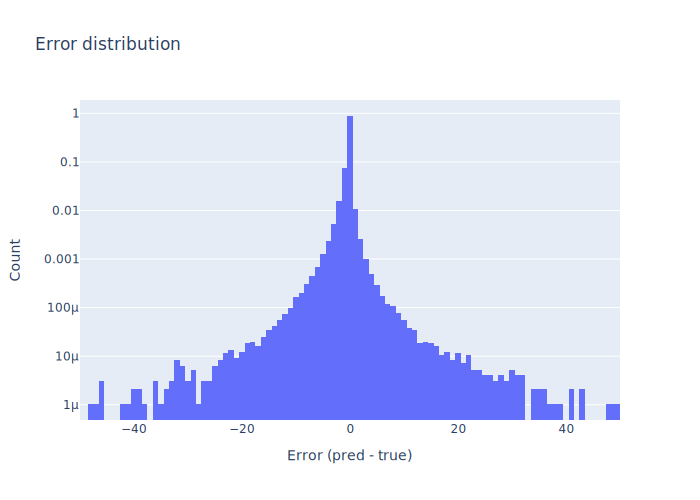

In [48]:
# Error dist
errors = pred_ - y_
fig = go.Figure(
    go.Histogram(x=errors, histnorm='probability'),
    layout=dict(title='Error distribution', xaxis_title='Error (pred - true)', yaxis_title='Count',
                width=700, height=500, yaxis_type='log', xaxis_range=(-50, 50))
)
fig.show('svg')

## Test Eval

In [55]:
from relbench.datasets import get_dataset

task = (
    get_dataset('rel-math-stackex', process=True)
    .get_task('rel-stackex-votes', process=True)
)

making Database object from raw files...
Loading data from: /Users/adobles/Library/Caches/pooch/25a03b9a227fa6fadbd949a4ea4721f2-relbench-stackex-raw/math-stackex-temp


/Users/adobles/projects/snap/relbench/relbench/datasets/math_stackex.py:56: DtypeWarning:

Columns (0,1,2,3,5) have mixed types. Specify dtype option on import or set low_memory=False.

/Users/adobles/projects/snap/relbench/relbench/datasets/math_stackex.py:62: DtypeWarning:

Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.



Data loaded
Percentage of rows removed due to invalid dates: 4.21%
Percentage of rows removed due to invalid dates: 0.00%
Percentage of rows removed due to invalid dates: 0.00%
Percentage of rows removed due to invalid dates: 0.00%
Percentage of rows removed due to invalid dates: 0.00%
Percentage of rows removed due to invalid dates: 0.00%
Percentage of rows removed due to invalid dates: 0.00%
done in 238.93 seconds.
reindexing pkeys and fkeys...
done in 50.94 seconds.


In [56]:
test_df = conn.sql('select * from votes_test_feats').df()
test_tf = train_dset.convert_to_tensor_frame(test_df.drop(DROP_COLS, axis=1))

In [58]:
pred = gbdt.predict(tf_test=test_tf)
preds = {pid: p for pid, p in zip(test_df.post_id, pred)}
pred = np.array([preds[pid] for pid in task.test_table.df.PostId])

In [59]:
task.evaluate(pred)

/Users/adobles/opt/anaconda3/envs/relbench/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.



{'mae': 0.15886062515964644, 'rmse': 0.7749784990793586}